In [17]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

from functions import *
from network import *

# INITIALIZATION

In [18]:
Nb_train = 1e3
Nb_test  = 1e4
M = 4
n = 2
SNRmin = 0
SNRmax = 24
SNRstep = 1
k = int(torch.log2(torch.tensor(M)))      #Number of bits on each symbol
[Nb_train,Ns_train,Nb_test,Ns_test] = correction(Nb_train,Nb_test,k,M,n)
Es = 1                   #Symbol energy
Eb = Es/k

# Channel matrix
H = torch.eye(n)
#H = torch.tensor(((1, 0.45),(0.25, 1)))
#H = torch.tensor(((1, 0.2),(1, 0.25)))

Hinv=torch.linalg.inv(H)

batch_size = Nb_train//4
valid_size = 0.2   # Percentage of training set to use as validation
verbose = 1

# NETWORK

In [19]:
# Initialize network
model = Net(M,n)

# Loss functions
criterion = nn.NLLLoss()

# Optimizer
optimizer = optim.Rprop(model.parameters(), lr=0.001)

In [20]:
model

Net(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
)

# TRAINING AND TEST

In [21]:
n_epochs = 150
patience = 20

berTrain = torch.empty(n,0)
berValid = torch.empty(n,0)
berTest  = torch.empty(n,0)

berZF    = torch.empty(n,0)
berLMMSE = torch.empty(n,0)
berML    = torch.empty(n,0)

# Train the network for each value of SNR
SNRdb = torch.arange(SNRmin,SNRmax,SNRstep) 
if verbose: print('Simulating SNR = ', end = '')
for ii in range(len(SNRdb)):
    if verbose: print('{}, '.format(SNRdb[ii]), end = '')
    
    # data generation
    [trainloader,validloader,testloader,x,alphabet] = create_datasets(H,Nb_train,
                                                                      Nb_test,Eb,
                                                                      M,n,
                                                                      SNRdb[ii],
                                                                      batch_size,
                                                                      valid_size)
    # restart weigths and bias
    model.restart()
    
    # train the model
    model, avg_train_losses, avg_valid_losses = train_model(model,
                                                            trainloader,
                                                            validloader,
                                                            optimizer,
                                                            criterion,
                                                            patience,
                                                            n_epochs)
    
    # visualize the loss as the network trained
    #printloss(avg_train_losses,avg_valid_losses,SNRdb[ii],save=False)
    
    # Calculate BER for training, validation and test data
    errorTrain, errorValid, errorTest = eval_model(model,trainloader,validloader,testloader,x,alphabet,k) 
    
    # BER of every SNR
    berTrain = torch.hstack((berTrain,errorTrain))
    berValid = torch.hstack((berValid,errorValid))    
    berTest = torch.hstack((berTest,errorTest))
    
    # Comparison with other detection methods
    Rn = torch.hstack((trainloader.dataset.Rn, validloader.dataset.Rn))
    Bn = torch.hstack((trainloader.dataset.Bn, validloader.dataset.Bn))
    
    SNR = 10**(SNRdb[ii]/10)      #Signal to Noise Ratio [n.u.]
    varzn = Eb/(2*SNR)                          #Noise variance

    errorZF = detect(Rn,Bn,H,alphabet,Nb_train,Ns_train,n,'ZF',Hinv=Hinv)
    errorLMMSE = detect(Rn,Bn,H,alphabet,Nb_train,Ns_train,n,'LMMSE',Es=Es,varzn=varzn)
    errorML = detect(Rn,Bn,H,alphabet,Nb_train,Ns_train,n,'ML',x=x)
    
    berZF = torch.hstack((berZF,errorZF))
    berLMMSE = torch.hstack((berLMMSE,errorLMMSE))
    berML = torch.hstack((berML,errorML)) 
    

Simulating SNR = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 

# BER

In [22]:
SNRdb2 = torch.arange(0,SNRmax,step=0.01)   #SNR array for theoretical calculus
SNR2 = 10**(SNRdb2/10)                  #SNR in natural units

serTheo = (2*(M-1)/M)*t_Qfunct(torch.sqrt((6*torch.log2(torch.tensor(M))/(M**2-1))*SNR2))
berTheo = serTheo/torch.log2(torch.tensor(M))

print('\nCalculating simulated bit error rate')
berTrainAv = sum(berTrain)/n
berValidAv = sum(berValid)/n
berTestAv = sum(berTest)/n

berZFav = sum(berZF)/n
berLMMSEav = sum(berLMMSE)/n
berMLav = sum(berML)/n



Calculating simulated bit error rate


# RESULTS


Showing results


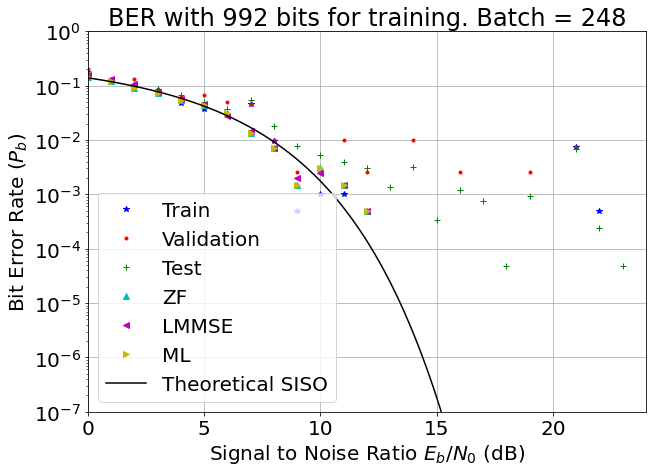

In [23]:
# Train and Validation Loss
print('\nShowing results')
legend = ('Train','Validation','Test','ZF','LMMSE','ML','Theoretical SISO')

font = {'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

plt.figure(1,figsize=(10,7))
plt.semilogy(SNRdb,berTrainAv,'*b',SNRdb,berValidAv,'.r',SNRdb,berTestAv,'+g')
plt.semilogy(SNRdb,berZFav,'^c',SNRdb,berLMMSEav,'<m',SNRdb,berMLav,'>y',SNRdb2,berTheo,'-k')
#plt.semilogy(SNRdb2,berTheo,'-k')
plt.axis([SNRmin,SNRmax,10**-7,1])
plt.grid()
plt.xlabel('Signal to Noise Ratio $E_b/N_0$ (dB)');
plt.ylabel('Bit Error Rate ($P_b$)');
plt.legend(legend, loc='lower left')
plt.title('BER with {} bits for training. Batch = {}'.format(Nb_train,batch_size))

plt.show()